# K-Means and Gaussian Mixture Model (GMM)

Janus, E5BDA, October 2020

Analyse some accelerometer data using K-means and GMM

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

### Load raw data

In [3]:
transport_data = pd.read_csv('2015-05-26_17-11-46.csv')
transport_data.set_index('loggingTime');

In [43]:
#transport_data.columns

### Make a dateseries that is purely change in speed (non-vectorial)

<AxesSubplot:>

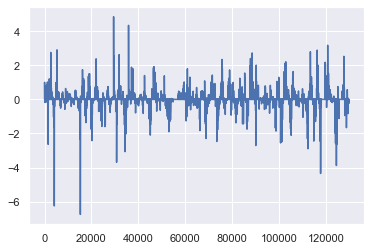

In [20]:
transport_data['d_speed'] = transport_data['locationSpeed'].diff()
transport_data['d_speed'].plot()

<AxesSubplot:ylabel='locationSpeed'>

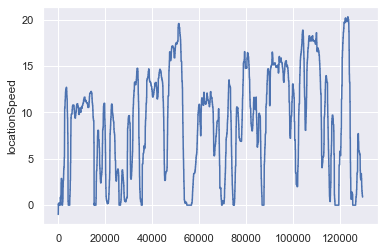

In [7]:
sns.lineplot(y='locationSpeed', x=range(len(transport_data)), data=transport_data)

Can this be augmented in a meaningful way with accelerometer data?

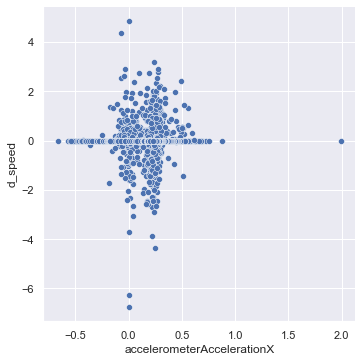

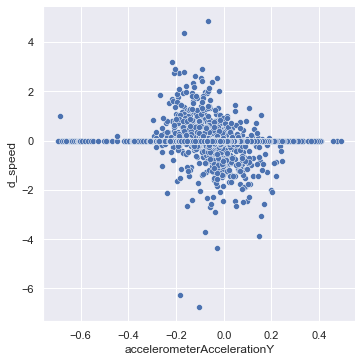

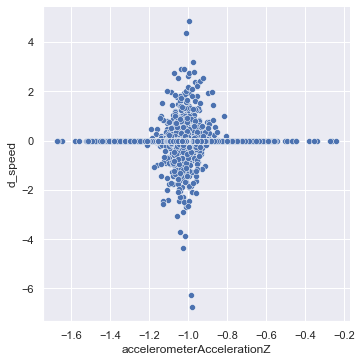

In [21]:
sns.relplot(y='d_speed', x='accelerometerAccelerationX', data=transport_data)
sns.relplot(y='d_speed', x='accelerometerAccelerationY', data=transport_data)
sns.relplot(y='d_speed', x='accelerometerAccelerationZ', data=transport_data)

The speed is not sampled with same frequency as the accel. It seems that accelerometer is placed so that accel. in the X direction changes measured speed.

Extract the three components of the acceleration vector

In [22]:
X = transport_data['accelerometerAccelerationX']  # d^2 x / dt^2
Y = transport_data['accelerometerAccelerationY']  # d^2 y / dt^2
Z = transport_data['accelerometerAccelerationZ']  # d^2 z / dt^2

Build dataset with planar acceleration, i.e. only $\ddot{x}$ and $\ddot{y}$

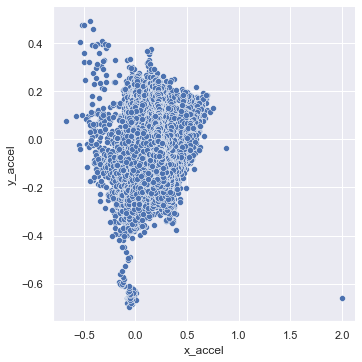

In [42]:
xy = pd.concat({'x_accel': X, 'y_accel': Y}, axis=1)
sns.relplot(x='x_accel', y='y_accel', data=xy)

Linear dataset with only $\dot{x}$

In [71]:
x = X.to_frame()   # Make a DataFrame instead of a Series object
x.columns = ['x_accel']  # Rename the column

<AxesSubplot:ylabel='x_accel'>

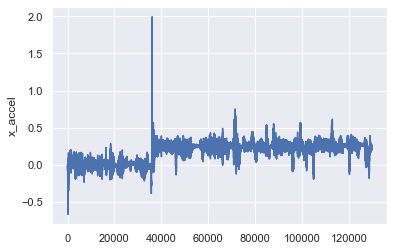

In [41]:
sns.lineplot(x=x.index, y='x_accel', data=x)

In [72]:
# Get location of the max
idx = x['x_accel'].idxmax()

In [73]:
# Compute detrending offset -> mean of x-acceleration after the bump
u = x['x_accel'][idx:].mean()
u

0.24120638839702288

That values appears correct when compared to the plot. Build a series for detrending

In [161]:
detrend = np.zeros(len(x))
detrend[idx:] = -x['x_accel'][idx]  # subtract the outlier
detrend[idx+1:] = -u                # subtract the mean
#detrend

In [162]:
# Perform detrending and view the detrended data
xd = (x['x_accel'] + detrend).to_frame()
#xd

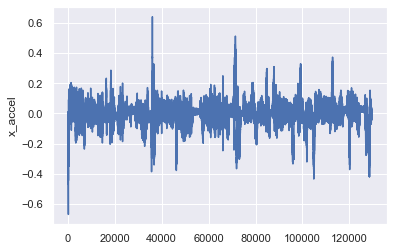

In [163]:
sns.lineplot(x=xd.index, y='x_accel', data=xd);

In [164]:
# Check detrended x-accel. vs. speed
#speed = transport_data['locationSpeed']
x_v_s = pd.concat({'x_accel': xd['x_accel'], 'd_speed': transport_data['d_speed']}, axis=1)

In [165]:
# x_v_s

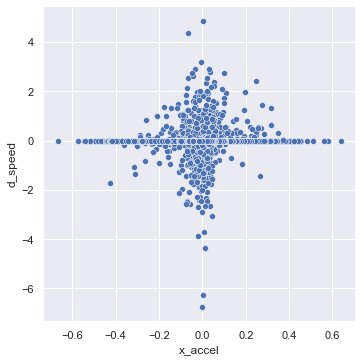

In [167]:
sns.relplot(x='x_accel', y='d_speed',  data=x_v_s);

There is no clear correlation here. Also, make a new planar series where the x is detrended.

In [168]:
xyd = xy.copy(deep=True)
xyd['x_accel'] = xd['x_accel']

## K-means

K-means is an unsupervised method to find _n_ clusters in the un-labelled multivariate data

In [169]:
from sklearn.cluster import KMeans

In [170]:
KMeans?

In general, there are 6 physical degrees of freedom for rigid-body motion in 3-space
- 3 rotations
- 3 translations

Here, we first want to try to get clusters for braking and speeding up

In [171]:
n = 3

In [172]:
kmeans_model = KMeans(n_clusters=n)

Then we can see the fitte _n_ cluster centers in 3-dimensional space

In [173]:
kmeans_model.fit(xyd)

KMeans(n_clusters=3)

In [174]:
kmeans_model.cluster_centers_

array([[ 0.01846409, -0.13696262],
       [ 0.00899793, -0.01402722],
       [-0.16978324, -0.10693562]])

What can it be used for?
We can use the clusters to label different types of motion

In [175]:
clusters = kmeans_model.fit_predict(xyd)

In [176]:
# clusters.shape

In [177]:
# Augment with cluster data
xy_clustered = xyd.copy(deep=True)
xy_clustered['cluster'] = pd.Series(clusters)

In [178]:
#xy_clustered

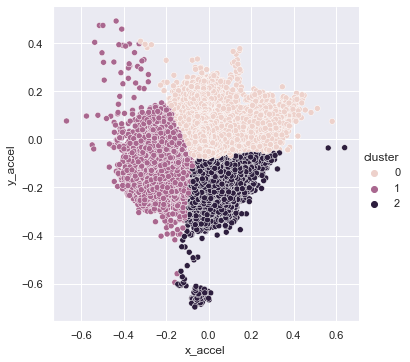

In [179]:
sns.relplot(x='x_accel', y='y_accel', data=xy_clustered, hue='cluster');

In [140]:
#speed_v_clusters = pd.concat({'speed': transport_data['locationSpeed'], 'cluster': pd.Series(clusters)}, axis=1)
#sns.relplot(x=x.index, y='speed', data=speed_v_clusters, hue='cluster')

## GMM

- Inspiration: [https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)

- Documentation: [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)

Import the model

In [220]:
from sklearn.mixture import GaussianMixture

Use the same number of components (clusters) as before

In [221]:
gmm_model = GaussianMixture(n_components=n)
gmm_model.covariance_type

'full'

In [222]:
gmm_model.fit(xyd)

GaussianMixture(n_components=3)

The predicted means, should (maybe) correspond to the K-means cluster centers

In [223]:
gmm_model.means_

array([[-0.02097506, -0.07070974],
       [ 0.00067991, -0.06577671],
       [ 0.00949888, -0.05009185]])

In [224]:
kmeans_model.cluster_centers_

array([[ 0.00899367, -0.01394447],
       [-0.16950291, -0.10694283],
       [ 0.0185095 , -0.13681787]])

In [225]:
gmm_clusters = gmm_model.predict(xyd)

In [226]:
xy_gmm_clustered = xyd.copy(deep=True)
xy_gmm_clustered['cluster'] = pd.Series(gmm_clusters)

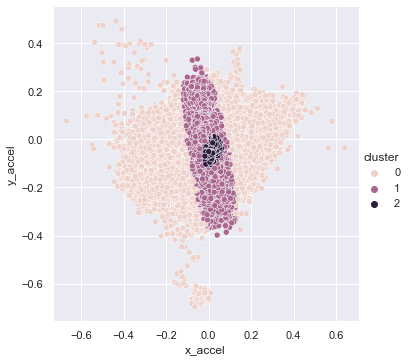

In [227]:
sns.relplot(x='x_accel', y='y_accel', data=xy_gmm_clustered, hue='cluster');

It is interesting, that this model places clusters quite differently than the K-means algorithm.

Also, if it is run multiple times, the clustering does not appear stable.

The model seems to cluster based on three modes
- Car constant velocity
- Constant x-velocity but y-acceleration (slight turning?)
- Car acceleration or braking due to throttle/brake, incl. some turning

In [228]:
gmm_model.converged_

True

Apparently, it has converged.